In [1]:
from IPython.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
from desdeo_emo.EAs import RVEA, NSGAIII
from desdeo_problem.testproblems.TestProblems import test_problem_builder
from desdeo_problem import DataProblem
from desdeo_tools.utilities import fast_non_dominated_sort, hypervolume_indicator

import matplotlib.pyplot as plt
import sklearn
from pyDOE import lhs
import pandas as pd

## Assignment 3

#### about acquisitio function in bayesian model management

## Task 1 

 Use EI and the mean prediction to solve any single objective benchmark problem (e.g.
Ackley, Rosenblock, sphere etc.) with any single objective optimizer (preferably GA). 

Set max exact function evaluations to 50 (start with 50 design points). Was the solutions
found by EI better? (you can implement EI is you wish to)

##### steps

voisi käyttää omaa GA, giomaran kurssilta. Siellä varmaan ratkaistu myös jokin single obj ongelma, täys pohja sieltä siihen. EI ja mean prediction ovat sitten se optimizer functio vaii?

max evals 50 ja 50 individuaalia..

mitä on mean prediction tässä tilanteessa? vai kuitenkin käytössä GRP ja GA on vaan optimizer? --  posterior predicted mean from Kriging surrogates <-- tässä varmaan mean prediction

Voisi eka ratkaista jollain helpolla ja sitten vähän vaikeemmalla kuten tuo hartmann jossa 6 lokaalia min ja 1 global ja 6 dims on x.

DOE meaning: 

In its simplest form, an experiment aims at predicting the outcome by introducing a change of the preconditions, which is represented by one or more independent variables, also referred to as "input variables" or "predictor variables." The change in one or more independent variables is generally hypothesized to result in a change in one or more dependent variables, also referred to as "output variables" or "response variables." 

Tämä slide:


Muistetaans nyt pääpointti. Meillä ei ole oikeita objektive funtioita käytössä tai liian kalliita. GRP sun muut on se kevyempi objektivefunctio. GA edelleen optimoija. data on populaation jäsenet decision space. laskettuna surrogatella GPR ne on surrogate objective space. Ja oikeilla sitten oikea objective space.

Oliko mean prediction error nyt sitten miten tämä mean prediction (surrogate) eroaa oikeasta mean ?

Easiest Approach (single objective)

- 1. Build surrogates with initial data (or DOE)
- 2. Optimize considering the mean prediction as objectives
- 3. Evaluate the solution with the expensive functions 
- 4. Rebuild the surrogates with the new data
- 5. Repeat Step 2 to Step 4 until maximum number of expensive function evaluation is reached

!!!! IMPORTATN !!!

we need to find the sampling points by optimizing the acf.

Acquicisiton functin (EI) shoudl be optimized?!



I  think it was actaully ok before, atleast it was using the easy single objective style.

Yea the github version is i think correct if I add optimizing the acquicisiton, be it just by sampling points or better.


I dont get anything, now it does not work again or smh.

In [5]:
# Problem is the expensive function to evaluate.
# use ackley


# prob takes now all as vectors, need to change GA to do so too.
def problem(x):
    # if only one solution to calculate
    if x.shape[0] == 2:
        term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x[0]**2 + x[1]**2)))
        term2 = np.exp(0.5 * (np.cos(2 * np.pi * x[0]) + np.cos(2 * np.pi * x[1])))
    else:
        term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x[:,0]**2 + x[:,1]**2)))
        term2 = np.exp(0.5 * (np.cos(2 * np.pi * x[:,0]) + np.cos(2 * np.pi * x[:,1])))
    return term1 - term2 + np.exp(1) + 20


In [6]:
problem(np.array([[4,4],[2,2],[2,4]]))

array([11.01342072,  6.59359908,  9.37428782])

## TODO:

Now somewhat works.



-- also need to try EI but should first get atleast surrogates to wrok

-- run several times

-- either make bounded SBX or comment about it possibly doing issues with crossover


In [262]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, RationalQuadratic, DotProduct, ConstantKernel, Matern

class real_GA:
    def __init__(self, problem, pop, pop_size, pm, bounds, di, order, fitness=None, acf=False, use_surr=False, max_func_evals=50, gen_max=50):
        self.problem = problem # problem function to solve
        self.pop = pop # pop array to hold binary population strings
        self.pm = pm # probability of mutation
        self.pop_size = pop_size # population size
        self.lbounds = bounds[0]
        self.ubounds = bounds[1]
        self.di = di # for crossover
        self.order = order # for mutation
        self.acf = acf
        self.use_surr = use_surr
        self.gen_max = gen_max # max generations
        self.max_func_evals = max_func_evals
        
        self.best_ind = None
        self.fitness = fitness # fitness array to hold calculated fitness values
        self.gen = 0 # current generation
        self.surr = None
        
    # start pop and evaluate each member in the pop
    def initialize(self):
        if len(self.pop) < 1:
            x1range = np.random.uniform(low=self.lbounds[0], high=self.ubounds[0], size=self.pop_size)
            x2range = np.random.uniform(low=self.lbounds[1], high=self.ubounds[1], size=self.pop_size)
            self.pop = np.stack((x1range, x2range), axis=-1)

        self.pop_size = self.pop.shape[0]
        #self.fitness = self.evaluate(self.pop)
        #print(self.fitness.shape)

    # run the GA for one iteration
    def run(self):
        n = 0 # init iterations
        self.initialize()

        # while self.gen_max > n:
        #for _ in range(1):
        next_gen = [] # init next_gen population array
        for i in range(int(self.pop.shape[0]/2)):
            # select two individuals with deterministic tournament selection, append them in a next gen list for crossover
            i1, i2 = self.tour_select()
            s1 = self.pop[i1]
            s2 = self.pop[i2]
            next_gen.append(s1)
            next_gen.append(s2)
            
        # crossover. Happens every time
        next_gen = self.SBX(next_gen)
            
        # Mutation. happens if rand < pm for member in pop
        for i in range(self.pop_size):
            if np.random.rand() < self.pm:
                next_gen[i] = self.poly_mutation(next_gen[i], self.order)
         
        self.pop = np.asarray(next_gen) # add next gen to self pop               
        #self.fitness = self.evaluate(self.pop)
        n += 1
        self.gen += 1       
        
        # evaluate the best individual with real func. TODO: to use this or not?
        self.best_ind = self.evaluate(self.pop[np.argmin(self.fitness)])
        #self.best_ind = self.pop[np.argmin(self.fitness)]
        #self.best_ind = np.min(self.fitness) # just put the best fitness val after opt
        
    
    # evaluate population members
    def evaluate(self, x):
        # constraint evaluation
        #if self.use_surr:
        #    return self.surr.predict(x)
        return problem(x)
        
        
    # deterministic binary tournament selection
    def tour_select(self):        
        cf = self.fitness
        b1 = np.argmin(cf) # get best member by fitness
        cf = np.delete(cf, b1) # remove it from cf
        b2 = np.argmin(cf) # get (2nd) best member by fitness
        return b1, b2 # return best and 2nd best members as parents
        
        
    # Simulated binary crossover (non-bounded)
    def SBX(self, parents):
        parents = np.asarray(parents)
        pop_size, num_var = parents.shape
        children = np.zeros_like(parents)
        for i in range(0, pop_size, num_var):
            p1 = (parents[i] + parents[i + 1]) / 2
            p2 = (parents[i] - parents[i + 1]) / 2
            beta = np.zeros(num_var)
            alpha = np.random.rand(num_var)
            bx = np.random.randint(0, high=2, size=num_var)
            beta[alpha <= 0.5] = (2 * alpha[alpha <= 0.5])**(1 / (self.di + 1))
            beta[alpha > 0.5] = (2 - 2 * alpha[alpha > 0.5])**(-1 / (self.di + 1))            
            beta = beta * ((-1)**bx)
            children[i] = p1 + beta * p2
            children[i + 1] = p1 - beta * p2
        return children
        
    
    # polynomial mutation for one pop member p
    def poly_mutation(self, p, order):
        children = np.array([0,0])
        for i in range(0, 2):
            pL = self.lbounds[i]
            pU = self.ubounds[i]
            u = np.random.random() # r [0,1]
            mp = 0
            dl = (2*u)**(1/1+order) - 1
            dr = 1 - (2*(1 - u))**(1/1+order) 
            if u <= 0.5:
                mp = p[i] + dl*(p[i] - pL)
            else:
                mp = p[i] + dr*(pU - p[i])
            children[i] = mp
        return children

In [252]:
# best fitness 1.3862981070613571
# best variable values [-0.05708943 -0.00045767]

# normal GA just gets stuck on some local min anytime.

# global optimum of ackley f(0,0) = 0.

In [307]:
def create_samples(dec_dim, samples, bounds):
    # create samples 
    x = lhs(dec_dim, samples)    
    # scale
    lower = bounds[0]
    upper = bounds[1]
    x = x * (upper - lower) + lower    
    return np.asarray(x)

In [308]:
# https://modal-python.readthedocs.io/en/latest/_modules/modAL/acquisition.html#max_EI
from scipy.stats import norm
from scipy.special import ndtr

def EI(mean, std, max_val, tradeoff):
    z = (mean - max_val - tradeoff) / std
    return (mean - max_val - tradeoff) * ndtr(z) + std * norm.pdf(z)

In [325]:
# params
pop_s = 50
pm = 0.1
bounds = np.array([[-2, -2], [2, 2]]) # variable bounds (lower, upper)
gen_max = 50
use_surr = True
fmax = 50 # max func evals
di = 2 # distribution index
order = 20 # polynomial order param
acf = True

times = 20

### Using mean pred

In [338]:
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor

mean_pred_result_all = []
use_EI = False

x = create_samples(2, pop_s, bounds)
pop = x
y = problem(x)
kernel = Matern(length_scale=1.0)

model = GaussianProcessRegressor(kernel,n_restarts_optimizer=1,random_state=7).fit(x, y)

ga = real_GA(problem, pop, pop_s, pm, bounds, di, order, y, acf, use_surr, fmax, gen_max) 

def surrogate(model, x):
    return model.predict(x, return_std=True)

def posteori_mean_pred(x, x_samples, model):
    # x = np.vstack((x, x_samples))
    return model.predict(x_samples)
    
def expected_impr(x, x_samples, model):
    #x = np.vstack((x, x_samples)) 
    mean, std = model.predict(x_samples, return_std=True)
    max_val = np.max(mean)
    tradeoff = 0.5

    return EI(mean, std, max_val, tradeoff)
    
# .. but this is still done by creating new samples eg. random search..
def opt_acq(x, y, model):
    x_samples = create_samples(2, 100, bounds)
    ix = 0
    if use_EI:
        scores = expected_impr(x, x_samples, model)
        ix = np.argmax(scores)
    else:
        scores = posteori_mean_pred(x, x_samples, model)
        ix = np.argmin(scores)
    return x_samples[ix]

for _ in range(times):
    fmax = 0
    while fmax < 50:
        best_x = opt_acq(x, y, model)
        
        true_y = problem(best_x) # + 1 fmax..
        fmax += 1
        
        est,  _ = surrogate(model, [best_x])
        #print(f"best x {best_x} estimate {est} actual {true_y}")
        
        # add to data. have to keep x, y == pop.size to not break GA currently.
        worst_y = np.argmax(y)
        x = np.delete(x, worst_y, axis=0)
        y = np.delete(y, worst_y, axis=0)
    
        x = np.vstack((x, [best_x]))
        y = np.hstack((y, [true_y]))
    
        # update surr
        model.fit(x, y)
        
        # no idea if this is making sense.
        ga.pop = x
        ga.fitness = y
      
        #n = 0
        #while n < 5:
        ga.run()
        #n += 1
            
    fittest_idx = np.argmin(ga.fitness)
    print("best surrogate fitness", ga.fitness[fittest_idx])
    print("best decision values", ga.pop[fittest_idx])
    print("best surr func value", true_y)
    print("best exact func value", ga.best_ind)
    
    mean_pred_result_all.append(ga.best_ind)

best surrogate fitness 0.14576087724346465
best decision values [ 0.01702712 -0.03402439]
best surr func value 7.315063331394597
best exact func value 0.14576087724346465
best surrogate fitness 0.14576087724346465
best decision values [ 0.01702712 -0.03402439]
best surr func value 7.6310960193769475
best exact func value 0.14576087724346465
best surrogate fitness 0.09214793786506448
best decision values [ 2. -1.]
best surr func value 6.808589550443987
best exact func value 5.422131717799509
best surrogate fitness 0.09214793786506448
best decision values [ 0.01658697 -0.02860447]
best surr func value 7.362969254375898
best exact func value 0.12241565052879011
best surrogate fitness 0.08421604940829397
best decision values [ 0.01769091 -0.01290324]
best surr func value 6.697486711637186
best exact func value 0.0746589273400069
best surrogate fitness 0.01971817500158579
best decision values [-0.00093513 -0.00807396]
best surr func value 6.583371632200098
best exact func value 0.0247474855

In [339]:
mean_pred_result_all

[0.14576087724346465,
 0.14576087724346465,
 5.422131717799509,
 0.12241565052879011,
 0.0746589273400069,
 0.024747485506082967,
 5.422131717799509,
 0.01597543967956483,
 0.07935207270297084,
 0.011266083507901925,
 0.11335493842296174,
 0.05056105544853651,
 0.17370447474473139,
 0.16709755583368846,
 0.11648946599175858,
 0.0304789945480195,
 0.0468439390574531,
 0.02188337589297973,
 0.044681013418472304,
 0.033421246474510724]

In [340]:
np.mean(mean_pred_result_all)

0.6131358454592188

### using EI

In [341]:
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor

EI_result_all = []

use_EI = True

x = create_samples(2, pop_s, bounds)
pop = x
y = problem(x)
kernel = Matern(length_scale=1.0)

model = GaussianProcessRegressor(kernel,n_restarts_optimizer=1,random_state=7).fit(x, y)

ga = real_GA(problem, pop, pop_s, pm, bounds, di, order, y, acf, use_surr, fmax, gen_max) 

def surrogate(model, x):
    return model.predict(x, return_std=True)

def posteori_mean_pred(x, x_samples, model):
    # x = np.vstack((x, x_samples))
    return model.predict(x_samples)
    
def expected_impr(x, x_samples, model):
    #x = np.vstack((x, x_samples)) 
    mean, std = model.predict(x_samples, return_std=True)
    max_val = np.max(mean)
    tradeoff = .7

    return EI(mean, std, max_val, tradeoff)
    
# .. but this is still done by creating new samples eg. random search..
def opt_acq(x, y, model):
    x_samples = create_samples(2, 100, bounds)
    ix = 0
    if use_EI:
        scores = expected_impr(x, x_samples, model)
        ix = np.argmin(scores)
    else:
        scores = posteori_mean_pred(x, x_samples, model)
        ix = np.argmin(scores)
    return x_samples[ix]

for _ in range(times):
    fmax = 0
    while fmax < 50:
    
        best_x = opt_acq(x, y, model)
        
        true_y = problem(best_x) # + 1 fmax..
        fmax += 1
    
        est,  _ = surrogate(model, [best_x])
        #print(f"best x {best_x} estimate {est} actual {true_y}")
        
        # add to data. have to keep x, y == pop.size to not break GA currently.
        worst_y = np.argmax(y)
        x = np.delete(x, worst_y, axis=0)
        y = np.delete(y, worst_y, axis=0)
    
        x = np.vstack((x, [best_x]))
        y = np.hstack((y, [true_y]))
    
        # update surr
        model.fit(x, y)
        ga.pop = x
        ga.fitness = y
      
        # ga runs for 1 iteration
        ga.run()
        

    fittest_idx = np.argmin(ga.fitness)
    print("best surrogate fitness", ga.fitness[fittest_idx])
    print("best decision values", ga.pop[fittest_idx])
    print("best surr func value", true_y)
    print("best exact func value", ga.best_ind)
    EI_result_all.append(ga.best_ind)

best surrogate fitness 0.2914259393094376
best decision values [-0.0275039   0.00059213]
best surr func value 2.6661564740626886
best exact func value 0.09783800789134744
best surrogate fitness 0.21082931373810965
best decision values [-0.06574273 -0.08706948]
best surr func value 2.6123816667001876
best exact func value 0.6015861191869725
best surrogate fitness 0.21082931373810965
best decision values [ 0.02424877 -0.06084117]
best surr func value 2.5585723721317173
best exact func value 0.29589280134965534
best surrogate fitness 0.07926330182462493
best decision values [ 0.02876492 -0.04914071]
best surr func value 1.2754966933821699
best exact func value 0.24545689887699496
best surrogate fitness 0.07926330182462493
best decision values [ 0.0248384  -0.05072062]
best surr func value 0.8537172779351785
best exact func value 0.24274204830550516
best surrogate fitness 0.07926330182462493
best decision values [ 0.0187926  -0.00795301]
best surr func value 1.6061623689036928
best exact f

In [342]:
EI_result_all

[0.09783800789134744,
 0.6015861191869725,
 0.29589280134965534,
 0.24545689887699496,
 0.24274204830550516,
 0.06877161248799624,
 0.09047723760712145,
 3.6253849384403622,
 0.03068651549056156,
 0.02451015077899754,
 0.024908490955915852,
 0.024241979308087025,
 0.02522240755323324,
 0.02974068093838511,
 0.022447597600752545,
 0.021752907545952382,
 0.1066663968581878,
 0.00178007319108886,
 0.04641344758645971,
 0.02034406741696415]

In [343]:
np.mean(EI_result_all)

0.28234321896852704

## TODO:

check code for mistakes.

make loops to run both algos atleast 10 times. Then can compare the results between runs.

-- for now EI one seems to work very nice. mean pred not so nice always, which might be as expected.


Was assuming EI will be better, but with several 20-run blocks there was no clear winner. Maybe due to GA implementation there is too much randomness? atleast SBX is not bounded maybe that.

In [275]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, RationalQuadratic, DotProduct, ConstantKernel, Matern

class real_GA2:
    def __init__(self, problem, pop, pop_size, pm, bounds, di, order, acf=False, use_surr=False, max_func_evals=50, gen_max=50):
        self.problem = problem # problem function to solve
        self.pop = pop # pop array to hold binary population strings
        self.pm = pm # probability of mutation
        self.pop_size = pop_size # population size
        self.lbounds = bounds[0]
        self.ubounds = bounds[1]
        self.di = di # for crossover
        self.order = order # for mutation
        self.acf = acf
        self.use_surr = use_surr
        self.gen_max = gen_max # max generations
        self.max_func_evals = max_func_evals
        
        self.func_evals = 0
        self.best_ind = None
        self.fitness = [] # fitness array to hold calculated fitness values
        self.gen = 0 # current generation
        self.surr = None
        
    
    # start pop and evaluate each member in the pop
    def initialize(self):
        if len(self.pop) < 1:
            x1range = np.random.uniform(low=self.lbounds[0], high=self.ubounds[0], size=self.pop_size)
            x2range = np.random.uniform(low=self.lbounds[1], high=self.ubounds[1], size=self.pop_size)
            self.pop = np.stack((x1range, x2range), axis=-1)
        
        self.fitness = np.array([self.evaluate(member) for member in self.pop]) # calculate fitness for each pop member
        

    # run the GA
    def run(self):
        n = 0 # init iterations
        self.initialize()
        
        # 1. building the surrogates with initial data
        if self.use_surr:
            # kernel = Matern(length_scale_bounds=(1e-10, 1000000))
            kernel = Matern(length_scale=1.0)
            self.surr = GPR(kernel,n_restarts_optimizer=1,random_state=7).fit(self.pop, self.fitness)

        # 2. optimize part ?
        while self.max_func_evals > self.func_evals:
            # evaluate the population members, using surrogates if wanted
            if self.surr is not None:
                best_pop = self.opt_acquicition()
                #self.pop = np.vstack((self.pop, best_pop))                
                # eval the solution with expesive functions
                best_fit = self.evaluate(best_pop)
                self.best_ind = best_fit
                self.func_evals += 1
                
                # remove worst individual, append new best individual
                # this GA needs to keep pop size the same
                worst_y = np.argmax(self.fitness)
                self.pop = np.delete(self.pop, worst_y, axis=0)
                self.fitness = np.delete(self.fitness, worst_y, axis=0)
                self.pop = np.vstack((self.pop, [best_pop]))
                self.fitness = np.hstack((self.fitness, [best_fit]))
                
                self.best_ind = best_fit          
                # rebuilt surrogates?
                self.update_surrogates()
            else:    
                self.fitness = np.array([self.evaluate(member) for member in self.pop])
            
            for _ in range(10):
                next_gen = [] # init next_gen population array
                for i in range(int(self.pop.shape[0]/2)):
                    # select two individuals with deterministic tournament selection, append them in a next gen list for crossover
                    i1, i2 = self.tour_select()
                    s1 = self.pop[i1]
                    s2 = self.pop[i2]
                    next_gen.append(s1)
                    next_gen.append(s2)
                    
                # crossover. Happens every time
                next_gen = self.SBX(next_gen)
                    
                # Mutation. happens if rand < pm for member in pop
                for i in range(self.pop_size):
                    if np.random.rand() < self.pm:
                        next_gen[i] = self.poly_mutation(next_gen[i], self.order)
                 
                self.pop = np.asarray(next_gen) # add next gen to self pop 
                # should evaluate the surrogate pop in ga, otherwise no direction or?
                self.fitness = self.surr.predict(self.pop)

                self.gen += 1
        
        
        # evaluate the best individual with real func. TODO: to use this or not?
        self.best_ind = self.evaluate(self.pop[np.argmin(self.fitness)])
        

    def update_surrogates(self):
        kernel = Matern(length_scale=1.0)
        self.surr = GPR(kernel,n_restarts_optimizer=1,random_state=7).fit(self.pop, self.fitness)
        #print("updating surr", self.surr.score(self.pop, self.fitness))

    # 2. ?
    def opt_acquicition(self):
        x_samples = create_samples(2, 100, bounds)
        ix = 0        
        if self.acf:
            scores = expected_impr(x, x_samples, model)
            ix = np.argmax(scores)
        else:
            scores = posteori_mean_pred(x, x_samples, model)
            ix = np.argmin(scores)
        return x_samples[ix]
    
    
    
    # evaluate population members
    def evaluate(self, member):
        # constraint evaluation       
        fitness = self.fitness_evaluation(member)
        return fitness
        
    # evaluates constraint violations and updates the fitness value by chosen penalty constraint method
    def fitness_evaluation(self, x):
        # constraint evaluation  
        #x, infeasible = check_constraints(x)
        fitness = problem(x)          
        return fitness
        
        
    # deterministic binary tournament selection
    def tour_select(self):        
        cf = self.fitness
        b1 = np.argmin(cf) # get best member by fitness
        cf = np.delete(cf, b1) # remove it from cf
        b2 = np.argmin(cf) # get (2nd) best member by fitness
        return b1, b2 # return best and 2nd best members as parents
        
        
    # Simulated binary crossover (non-bounded)
    def SBX(self, parents):
        parents = np.asarray(parents)
        pop_size, num_var = parents.shape
        children = np.zeros_like(parents)
        for i in range(0, pop_size, num_var):
            p1 = (parents[i] + parents[i + 1]) / 2
            p2 = (parents[i] - parents[i + 1]) / 2
            beta = np.zeros(num_var)
            alpha = np.random.rand(num_var)
            bx = np.random.randint(0, high=2, size=num_var)
            beta[alpha <= 0.5] = (2 * alpha[alpha <= 0.5])**(1 / (self.di + 1))
            beta[alpha > 0.5] = (2 - 2 * alpha[alpha > 0.5])**(-1 / (self.di + 1))            
            beta = beta * ((-1)**bx)
            children[i] = p1 + beta * p2
            children[i + 1] = p1 - beta * p2
        return children
        
    
    # polynomial mutation for one pop member p
    def poly_mutation(self, p, order):
        children = np.array([0,0])
        for i in range(0, 2):
            pL = self.lbounds[i]
            pU = self.ubounds[i]
            u = np.random.random() # r [0,1]
            mp = 0
            dl = (2*u)**(1/1+order) - 1
            dr = 1 - (2*(1 - u))**(1/1+order) 
            if u <= 0.5:
                mp = p[i] + dl*(p[i] - pL)
            else:
                mp = p[i] + dr*(pU - p[i])
            children[i] = mp
        return children

In [276]:
# params
pop_s = 50
pm = 0.1
bounds = np.array([[-1, -1], [1, 1]]) # variable bounds (lower, upper)
gen_max = 50
use_surr = True
fmax = 50 # max func evals
di = 2 # distribution index
order = 20 # polynomial order param

times = 20

In [244]:
mean_pred_result_all = []

#for _ in range(times):
acf = False # use acquicisition function EI
pop = create_samples(2, pop_s, bounds)

for _ in range(times):
    ga = real_GA2(problem, pop, pop_s, pm, bounds, di, order, acf, use_surr, fmax, gen_max) 
    ga.run()
    
    print(ga.max_func_evals)
    print(ga.gen)
    
    fittest_idx = np.argmin(ga.fitness)
    print("best surrogate fitness", ga.fitness[fittest_idx])
    print("best decision values", ga.pop[fittest_idx])
    print("best exact func value", ga.best_ind)
    mean_pred_result_all.append(ga.best_ind)

50
500
best surrogate fitness -1.8407508587627035
best decision values [ 0.95415412 -0.61315011]
best exact func value 4.5764226026423
50
500
best surrogate fitness -2.013144214640249
best decision values [ 1.02965539 -0.16353426]
best exact func value 3.343388380707996
50
500
best surrogate fitness -0.2683448900703631
best decision values [ 0. -1.]
best exact func value 2.637531092108304
50
500
best surrogate fitness -0.3548156428159359
best decision values [0.33813731 0.36167462]
best exact func value 3.514077875471969
50
500
best surrogate fitness -1.3093580334893318
best decision values [0.37165324 0.40008007]
best exact func value 3.732625961868429
50
500
best surrogate fitness -1.2030104990877284
best decision values [ 0.15356212 -0.64161037]
best exact func value 3.5294643845947213
50
500
best surrogate fitness -5.0102144655284064e-12
best decision values [1.25934307 0.67518703]
best exact func value 5.603404055733019
50
500
best surrogate fitness -1.5661480992423549
best decisi

In [245]:
mean_pred_result_all

[4.5764226026423,
 3.343388380707996,
 2.637531092108304,
 3.514077875471969,
 3.732625961868429,
 3.5294643845947213,
 5.603404055733019,
 6.02090000979166,
 10.51492615634743,
 4.482597266214203,
 2.9479166174367393,
 6.441685520007809,
 4.578988463270466,
 2.360022240901781,
 11.930101594334648,
 5.6032417986893925,
 4.203473175694331,
 3.0025006114793946,
 4.294006834720502,
 3.5735911387135566]

In [246]:
np.mean(mean_pred_result_all)

4.844543289036432

In [247]:
EI_result_all = []

for _ in range(times):
    acf = True # use acquicisition function EI
    pop = create_samples(2, pop_s, bounds)

    ga = real_GA2(problem, pop, pop_s, pm, bounds, di, order, acf, use_surr, fmax, gen_max) 
    ga.run()
    fittest_idx = np.argmin(ga.fitness)
    print("best surrogate fitness", ga.fitness[fittest_idx])
    print("best decision values", ga.pop[fittest_idx])
    print("best exact func value", ga.best_ind)
    EI_result_all.append(ga.best_ind)

best surrogate fitness -0.8803992814406474
best decision values [-0.50473694 -0.54247599]
best exact func value 4.333464183163539
best surrogate fitness -0.7693100406119839
best decision values [-2.72600847 -1.67959931]
best exact func value 9.25266973924587
best surrogate fitness -0.5163255046725066
best decision values [-0.97226183 -9.75737029]
best exact func value 16.045884377907672
best surrogate fitness -2.3615938320932823
best decision values [-3.38470147  1.47682301]
best exact func value 10.435273458797562
best surrogate fitness -1.0854356622597834
best decision values [-3.42867302 -0.92928939]
best exact func value 9.615691856270324
best surrogate fitness -0.9085487142139413
best decision values [-1.5066849  -0.58625614]
best exact func value 6.410591989058968
best surrogate fitness 0.0
best decision values [-1. -1.]
best exact func value 3.6253849384403622
best surrogate fitness -0.2767260011637802
best decision values [-4.56784658e-05 -1.28170650e+00]
best exact func value 

In [248]:
EI_result_all

[4.333464183163539,
 9.25266973924587,
 16.045884377907672,
 10.435273458797562,
 9.615691856270324,
 6.410591989058968,
 3.6253849384403622,
 4.540534457140193,
 8.952718764658528,
 15.997557143885182,
 0.0,
 2.637531092108304,
 3.7211852026515615,
 2.637531092108304,
 19.609036131055856,
 2.637531092108304,
 3.6253849384403622,
 4.549201445195461,
 0.0,
 0.0]

In [249]:
np.mean(EI_result_all)

6.431358595111817

#### Botorch stuff

## Task 2

Solve any benchmark problems (K=2 and 5, n=10) with ParEGO and LCB.
Start with 109 design points. Compare the hypervolume of the solutions after 100 exact function
evaluations.

#### Notes

$$
LCB(x) = \mu(x) - \beta \sigma (x)
$$

β is a parameter controlling the
degree of exploration


Maybe try Botorch? now reason to try the framework!

https://botorch.org/tutorials/multi_objective_bo

has example here how to use parEGo

https://github.com/shinya-ml/Multiobj-Bayes-opt

Basically, MOPGI, custom class wrapper for Gpy's GPR to handle multiple outputs. Has also predict method using NSGA-II as the optimizer. Query dataset.get_observed seems to be the part where calls the optim.

Then max iter loop for ParEGO, optim, fit using MOPGI, until done.

##### steps

- LHS? to generate 109 design points
- LCB and ParEGO are acquisition fucntions.. Use NSGA-III or whatever as the optimizer.


ParEGO

1. Draw random weight vector λ
2. Scalarize the objectives (using ASF) for the
provided data
3. Build GP on the scalarized objectives
4. Maximize EI
5. Evaluate and Repeat from step 1

-- use LCB first, simpler.

In [ ]:
# https://github.com/yunshengtian/DGEMO/blob/master/mobo/mobo.py

# idea how Multiobjective bayesian optimization goes

# if nothing else use this repo bc it should be able to do the things

In [20]:
def LCB(mean, std, beta=.5):
    return mean - beta*std

In [13]:
#https://github.com/automl/SMAC3/blob/main/smac/optimizer/multi_objective/parego.py

#rho = 0.05

# Then we have to compute the weight
theta = self.rng.rand(self.num_obj
# Normalize st all theta values sum up to 1
theta = theta / (np.sum(theta) + 1e-10
#Weight the values
theta_f = theta * valuereturn np.max(theta_f, axis=1) + self.rho * np.sum(theta_f, axis=1)

SyntaxError: invalid syntax (2459848700.py, line 8)

In [224]:
n_obj = 2
n_var = 10
dtlz5_2 = test_problem_builder('DTLZ5', n_of_variables=n_var, n_of_objectives=n_obj)
bounds = np.array([[0]*n_var, [1]*n_var])

In [225]:
x = create_samples(n_var, 109, bounds)
x[:1]

array([[0.58719674, 0.74785616, 0.3923076 , 0.50269711, 0.57299468,
        0.14246074, 0.32962119, 0.56221877, 0.8824898 , 0.60672576]])

In [226]:
y = dtlz5_2.evaluate(x)
y.objectives[:5]
y = y.objectives
y1 = y[:,0]
y2 = y[:,1]

In [227]:
x_names = [f'x{i}' for i in range(1,11)]
y_names = ["f1", "f2"]

data = pd.DataFrame(np.hstack((x,y)), columns=x_names+y_names)
#data

In [228]:
# problem = DataProblem(data=data, variable_names=x_names, objective_names=y_names)

In [229]:
## params

#x_bound = np.zeros(10)
#rho = 0.
#xi = 1.

kernel = Matern(length_scale=1.0)

gprs = []
# create gprs
for i in range(n_obj):
    print(i)
    gprs.append(GPR(kernel,n_restarts_optimizer=1,random_state=7).fit(x, y[:,i]))

print(gprs)   
    
#gpr1 = GPR(kernel,n_restarts_optimizer=1,random_state=7).fit(x, y1)
#gpr2 = GPR(kernel,n_restarts_optimizer=1,random_state=7).fit(x, y2)

0
1
[GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=1.5),
                         n_restarts_optimizer=1, random_state=7), GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=1.5),
                         n_restarts_optimizer=1, random_state=7)]


In [230]:

for i in range(2):
    # predict with surrogates
    y_preds = []
    stds = []
    
    # create 10 new samples ?
    x = np.vstack((x, create_samples(n_var, 10, bounds)))
    
    for gpr in gprs:
        y1_pred, std = gpr.predict(x, return_std=True)
        y_preds.append(y1_pred)
        stds.append(std)
    #y2_pred, std2 = gpr2.predict(x, return_std=True) 
    
    # ypreds and std now have n_obj amount of np.arrays. To get one just use: y_preds[0] eg for first one.
    print(y_preds)
    
    # calc LCB
    #y1_lcb = LCB(y1_pred, std1)
    #y2_lcb = LCB(y2_pred, std2)
    
    #y1_idx = np.argmin(y1_lcb)
    #y2_idx = np.argmin(y2_lcb)

    # add to data ?
    #x = np.append(x, [y1_idx])
    

[array([0.84357078, 0.56154479, 1.54343402, 1.45377182, 0.37747643,
       1.06103076, 0.62867658, 0.96122758, 1.40706153, 1.85578989,
       0.16113716, 1.59466936, 1.41569017, 0.75816532, 1.8237145 ,
       0.77737954, 1.41165004, 1.15650311, 1.33769728, 0.42206558,
       0.62686486, 1.09549569, 0.41348917, 0.34377553, 1.45423065,
       1.75300867, 0.59378434, 1.03217908, 0.40779123, 0.61331172,
       0.84789784, 1.54428969, 1.6477932 , 1.36684213, 1.84241149,
       0.57096248, 0.92082799, 1.23277878, 1.25385817, 0.08982221,
       1.16347288, 0.2180288 , 1.01677086, 0.04325407, 0.93064718,
       0.3160316 , 0.15868465, 1.67906224, 1.42112184, 1.06059372,
       1.72392075, 0.89626865, 0.18991806, 1.74025062, 0.72236028,
       1.66065463, 1.33196702, 0.89312047, 1.59388247, 1.28672444,
       1.44766143, 0.61362394, 1.28787974, 1.32635314, 1.3295312 ,
       1.44067095, 1.58376724, 1.80942358, 1.87418853, 0.11941385,
       1.4625602 , 1.59987687, 0.80600641, 1.4047618 , 0.8163

In [179]:
class ParEGO():
    """
    This class keep attributes and method about ParEGO
    Attributes
    ----------
    x_bounds : list
        input domain which is optimized.
    x_train : numpy.array
        observed input data
    y_train : numpy.array
        observed output data
    rho : float
        hyper parameter in chebyshev scalarization
    xi : float
        hyper parameter in Expected Improvement
    """
    def __init__(self, x_bounds, x_train, y_train, rho, xi):
        self.x_bounds = x_bounds
        self.x_train = x_train
        self.y_train = y_train
        self.rho = rho
        self.xi = xi
        self.task_num = y_train.shape[1]
        self.train_num = y_train.shape[0]
        self.f_theta = np.zeros(self.train_num)
    def calc_parego(self):
        """
        get the result of optimized ParEGO
        """
        self.scalarization()
        # res = minimize(self.EI, bounds=self.x_bounds, algomethod=1)
        res = self.EI()
        return res
    def scalarization(self):
        """
        scalarize observed output data
        """

        theta = np.random.random_sample((self.task_num))

        sum_theta = np.sum(theta)
        theta = theta / sum_theta
        
        theta_f = theta * self.y_train
        max_k = np.max(theta_f, axis = 1)
        rho_sum_theta_f = self.rho * np.sum(theta_f, axis = 1)
        self.f_theta = max_k + rho_sum_theta_f
    def obj(self, x):
        if np.any(np.all(self.x_train == x, axis=1)):
            return 1.0e5
        else:
            mean, var = self.model.predict(np.atleast_2d(x))
            std = np.sqrt(var[0,0])

            # mean_inv = (-1) * mean
            current_max = self.f_theta.max()
            # print(current_max)
            Z = (current_max - mean[0,0] - self.xi) / std
            # print(norm.cdf(Z))
            # print(norm.pdf(Z))
            ei = (-1) * (Z * std) * norm.cdf(Z) + std * norm.pdf(Z)
            # print(ei)
            return ei
    def EI(self):
        """
        construct a GP model for scalarized output data
        applying EI for this model
        """
        kernel = GPy.kern.RBF(self.x_train.shape[1])
        self.model = GPy.models.GPRegression(self.x_train, self.f_theta[:,None],kernel=kernel, normalizer=None)
        self.model['.*Gaussian_noise.variance'].constrain_fixed(1.0e-2)
        self.model['.*rbf.variance'].constrain_fixed(1.0)

        x_dist = distance.cdist(self.x_train, self.x_train)
        median = np.median(x_dist)
        if median == 0:
            lower = 1.0e-3
            upper = 100
        else:
            lower = 1.0e-3 * median
            upper = 100  * median
        self.model['.*rbf.lengthscale'].constrain_bounded(lower, upper)
        self.model.optimize_restarts()

        array_bounds = np.array(self.x_bounds)
        max_bound = np.argmax(array_bounds[:,0] - array_bounds[:,1])
        terminate_vol = (0.1 ** self.x_train.shape[1]) / (array_bounds[max_bound, 1] - array_bounds[max_bound, 0])
        res = minimize(self.obj, bounds = self.x_bounds, algmethod=1,volper = terminate_vol)
        return res

In [180]:
data[:5]

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,f1,f2
0,0.560775,0.124008,0.308101,0.398957,0.725020,0.639573,0.283232,0.424593,0.467520,0.242308,0.877493,1.063341
1,0.423274,0.493814,0.365374,0.508758,0.106245,0.995189,0.289963,0.987092,0.046779,0.580918,1.504593,1.179525
2,0.168388,0.929267,0.337976,0.094917,0.636774,0.272181,0.410702,0.074885,0.081247,0.608744,1.757766,0.476090
3,0.008066,0.255611,0.774269,0.346813,0.877044,0.239686,0.338721,0.934012,0.470484,0.229505,1.656624,0.020991
4,0.094010,0.908879,0.864651,0.307506,0.202080,0.121143,0.065626,0.829762,0.758206,0.637416,1.931223,0.287277


In [182]:
from desdeo_problem.surrogatemodels import GaussianProcessRegressor


#problem.train(GaussianProcessRegressor, {"kernel": Matern(1.0)}) # train will do the fit with x, and y.

for i in range(10):
    
    #res = parego.cal_parego()
    
    print('-----result of DIRECT-----')
    print(res)
    
    initial_x = np.append(initial_x, [res.x], axis=0)
    # get next y
    next_y = 0
    initial_y = np.append(initial_y, [next_y], axis=0)
    
    data = pd.DataFrame(np.hstack((initial_x,initial_y.objectives)), columns=x_names+y_names)
    problem = DataProblem(data=data, variable_names=x_names, objective_names=y_names)
    problem.train(GaussianProcessRegressor, {"kernel": Matern(1.0)}) # train again with new data

AttributeError: 'list' object has no attribute 'shape'

In [162]:
## desdeo example

from desdeo_problem.surrogatemodels import GaussianProcessRegressor

problem.train(GaussianProcessRegressor, {"kernel": Matern(nu=3/2)})

evolver_G_opt = NSGAIII(problem, use_surrogates=True, selection_type="optimistic")
while evolver_G_opt.continue_evolution():
    evolver_G_opt.iterate()

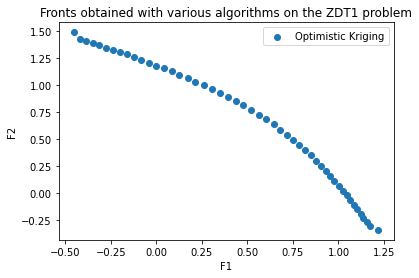

In [163]:
front_G_opt = evolver_G_opt.population.objectives - evolver_G_opt.population.uncertainity


G_opt = plt.scatter(x=front_G_opt[:,0], y=front_G_opt[:,1], label="Optimistic Kriging")

plt.title(f"Fronts obtained with various algorithms on the {problem_name} problem")
plt.xlabel("F1")
plt.ylabel("F2")
plt.legend()